To open in Google Colab click here: https://drive.google.com/file/d/1IQByqNejVcge_50V034nro9L7ndT7OGK/view?usp=sharing

# Women in AI & Robotics

## Implementing LLMs and fine-tuning them

### October 2023

We are implementing an open-source LLM called DistilBERT to predict the humor rating in social media posts. We will then fine-tune the model to analyse the performances.


In [ ]:
!pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Social Media Processing using BERT

This notebook shows how to use HuggingFace's package to import and train regression models to assess humor rating in social media posts in English (SemEval2021: HaHackathon: Detecting and Rating Humor and Offense https://competitions.codalab.org/competitions/27446, **Task-1b**).

Detection of humour, especially in social media posts, poses a linguistic challenge to NLP, due to the noise, figurative language, contextuality and subjectivity. You will hence try different methods to address those challenges such as preprocessing, data augmentation, ensembling and multi-task learning.

We will download and unzip the data from here: http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip.


Please make sure you are using the Colab TPU provided by Google.

In [ ]:
!wget http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
!unzip '/content/hahackathon_data.zip'

--2023-04-24 00:57:43--  http://smash.inf.ed.ac.uk/hahackathon_data/hahackathon_data.zip
Resolving smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)... 129.215.10.97
Connecting to smash.inf.ed.ac.uk (smash.inf.ed.ac.uk)|129.215.10.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571603 (558K) [application/zip]
Saving to: ‘hahackathon_data.zip.1’

hahackathon_data.zi 100%[===================>] 558.21K  1.03MB/s    in 0.5s    

2023-04-24 00:57:44 (1.03 MB/s) - ‘hahackathon_data.zip.1’ saved [571603/571603]

Archive:  /content/hahackathon_data.zip
replace hahackathon data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hahackathon data/.DS_Store  
replace __MACOSX/hahackathon data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/hahackathon data/._.DS_Store  
replace hahackathon data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hahackathon data/test.csv  
replace __MACOSX/hahackathon data/._test.csv? [y]es, [n]o

First, we need to install Hugging Face [transformers](https://huggingface.co/transformers/index.html) and [Sentence piece Tokenizers](https://github.com/google/sentencepiece), as well as some helper libraries, with the following commands.

In [ ]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q  ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import keras
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.layers.core import Dense
from keras.layers import Input, GlobalAveragePooling1D
from keras.models import Model
from keras import backend as K

We define the fix seed method to be able to introduce variety into ensembling models.

In [ ]:
def set_random_seed(seed=123):
  random.seed(seed)
  np.random.seed(seed)

set_random_seed()

## Regression with BERT

We will use the [DistilBert](https://arxiv.org/abs/1910.01108v4) model and its Tokeniser. Feel free to play around with the bacth size and the number of epochs. You might see a difference in the performance.

In [ ]:
from transformers import DistilBertTokenizer
import tqdm

# we will pad to 128 subword tokens
PAD_LENGTH = 128
bert = 'distilbert-base-uncased'
BATCH_SIZE = 512
EPOCHS =10

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=PAD_LENGTH, padding='max_length', truncation=True)

def tokenize(sentences, tokenizer, pad_length=PAD_LENGTH):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return (np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32'))


Let's read the data using Pandas.

In [ ]:
import pandas as pd

# Load data with only the necessary columns
train_df = pd.read_csv('hahackathon data/train.csv', usecols = ['text','humor_rating','offense_rating'])
test_df = pd.read_csv('hahackathon data/test.csv', usecols = ['text','humor_rating','offense_rating'])

# Drop the Nans
train_df = train_df.dropna()
test_df = test_df.dropna()

Let's check a couple of examples.

In [ ]:
train_df

,text,humor_rating,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,2.42,0.20
1,A man inserted an advertisement in the classif...,2.50,1.10
2,How many men does it take to open a can of bee...,1.95,2.40
3,Told my mom I hit 1200 Twitter followers. She ...,2.11,0.00
4,Roses are dead. Love is fake. Weddings are bas...,2.78,0.10
...,...,...,...
7991,"Sins are like viruses, it's better you keep th...",2.13,0.10
7993,My daughter wanted a Cinderella themed birthda...,3.70,0.00
7996,Why are aspirins white? Because they work sorry,1.33,3.85
7997,"Today, we Americans celebrate our independence...",2.55,0.00


In [ ]:
# Get the post text
train_examples_list = train_df['text'].tolist()
test_examples_list = test_df['text'].tolist()

# Get the humour rating for the regression task (we normalise, the values are between 0 and 5)
train_targets_list = (train_df['humor_rating']/5).tolist()
test_targets_list = (test_df['humor_rating']/5).tolist()

In [ ]:
def get_bert_inputs(examples_list, targets):
  input_ids=list()
  attention_masks=list()

  bert_inp=tokenize(examples_list, tokenizer)
  input_ids = bert_inp[0]
  attention_masks = bert_inp[1]

  targets = np.array(targets)

  return input_ids, attention_masks, targets

train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)


**Task 1: Build a neural bag of words model using DistilBERT embeddings and the sigmoid activation on the output layer for the regression task.**


In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig
from transformers.models.gpt_neox.modeling_gpt_neox import attention_mask_func
import tensorflow as tf


class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False

  return TFDistilBertModel.from_pretrained(distil_bert, config = config)

def create_regression_BoW_bert():

  hdepth=16
  MAX_SEQUENCE_LENGTH = 128
  EMBED_SIZE=100

  # create input layer
  input_ids = Input(shape=(128,), dtype='int32')
  input_masks_ids = Input(shape=(128,), dtype='int32')

  # get BERT layer
  bert = get_BERT_layer()

  # create bert layer
  bert_layer = bert(input_ids, attention_mask=input_masks_ids)[0]

  # create pooling layer
  pooling_layer = GlobalAveragePooling1DMasked()(bert_layer)

  # add hidden neurons
  hidden_layer = Dense(hdepth, input_shape=(MAX_SEQUENCE_LENGTH, EMBED_SIZE), activation='sigmoid')(pooling_layer)

  # add output layer
  out_reg = Dense(1, input_shape=(hdepth,), activation='sigmoid')(hidden_layer)

  # return model
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs=[out_reg])

# play around with learning rate value, what do you see?
def get_model(use_tpu=True, use_gpu=False, learning_rate=2e-5):
  if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model on TPU:
    with strategy.scope():
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  elif use_gpu:
    device_name = tf.test.gpu_device_name()
    print(device_name)
    with tf.device('/device:GPU:0'):
      model = create_regression_BoW_bert()
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  else:
    model = create_regression_BoW_bert()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


model = get_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_19 (TFDis  TFBaseModelOutput(l  66362880   ['input_39[0][0]',               
 tilBertModel)                  ast_hidden_state=(N               'input_40[0][0]']               
                                one, 128, 768),                                                   
                                 hidden_states=None                                        

In [ ]:
history = model.fit([train_input_ids, train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Epoch 1/10
10/10 [==============================] - 91s 4s/step - loss: 0.0145 - mean_squared_error: 0.0144
Epoch 2/10
10/10 [==============================] - 2s 186ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 3/10
10/10 [==============================] - 2s 187ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 4/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 5/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 6/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 7/10
10/10 [==============================] - 2s 188ms/step - loss: 0.0099 - mean_squared_error: 0.0100
Epoch 8/10
10/10 [==============================] - 2s 183ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 9/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 10/10


We evaluate our model on the test set.

In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test Accuracy:', results[1])

20/20 [==============================] - 10s 139ms/step - loss: 0.0143 - mean_squared_error: 0.0139
Test loss: 0.014315152540802956
Test MSE: 0.013892611488699913


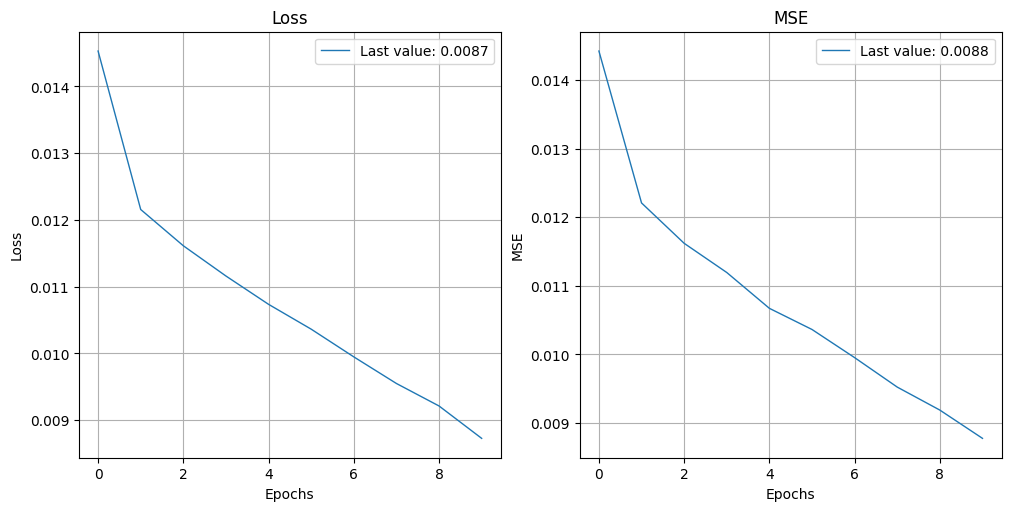

In [ ]:
from plot_keras_history import plot_history
plot_history(history.history, path="std.png")
plt.show()

Get the array of predictions here so that you can plot the outputs later.

In [ ]:
preds = model.predict(
      [test_input_ids,test_attention_masks],
      batch_size=None,
      verbose="auto",
      steps=None,
      callbacks=None,
      max_queue_size=10,
      workers=1,
      use_multiprocessing=False)

preds = np.array(preds).flatten()

20/20 [==============================] - 9s 311ms/step


# Feature Engineering & Data Augmentation

**Task 2: Preprocess the textual data with the Ekphrasis library following the standard pipeline https://github.com/cbaziotis/ekphrasis#text-pre-processing-pipeline. How does this affect the performance?**

In [ ]:
!pip install -q ekphrasis
!pip3 install -q emoji==0.6.0

In [ ]:
# import library packages
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# create the text preprocessor
text_processor = TextPreProcessor(

    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],

    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [ ]:
new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]


In [ ]:
print("Original Text:", train_examples_list[0])
print("Preprocessed Text:", new_train_examples_list[0])

Original Text: TENNESSEE: We're the best state. Nobody even comes close. *Elevennessee walks into the room* TENNESSEE: Oh shit...
Preprocessed Text: tennessee : we are the best state . nobody even comes close . * elevennessee walks into the room * tennessee : oh shit . . .


In [ ]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(new_train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(new_test_examples_list, test_targets_list)

model = get_model()
history = model.fit([train_input_ids,train_attention_masks],
                    train_targets,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
10/10 [==============================] - 89s 4s/step - loss: 0.0163 - mean_squared_error: 0.0161
Epoch 2/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 3/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 4/10
10/10 [==============================] - 2s 185ms/step - loss: 0.0113 - mean_squared_error: 0.0112
Epoch 5/10
10/10 [==============================] - 2s 180ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 6/10
10/10 [==============================] - 2s 181ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 7/10
10/10 [==============================] - 2s 189ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 8/10
10/10 [==============================] - 2s 182ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 9/10
10/10 [==============================] - 2s 186ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 10/10


In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test Accuracy:', results[1])

20/20 [==============================] - 11s 139ms/step - loss: 0.0129 - mean_squared_error: 0.0125
Test loss: 0.012899475172162056
Test MSE: 0.01253219973295927


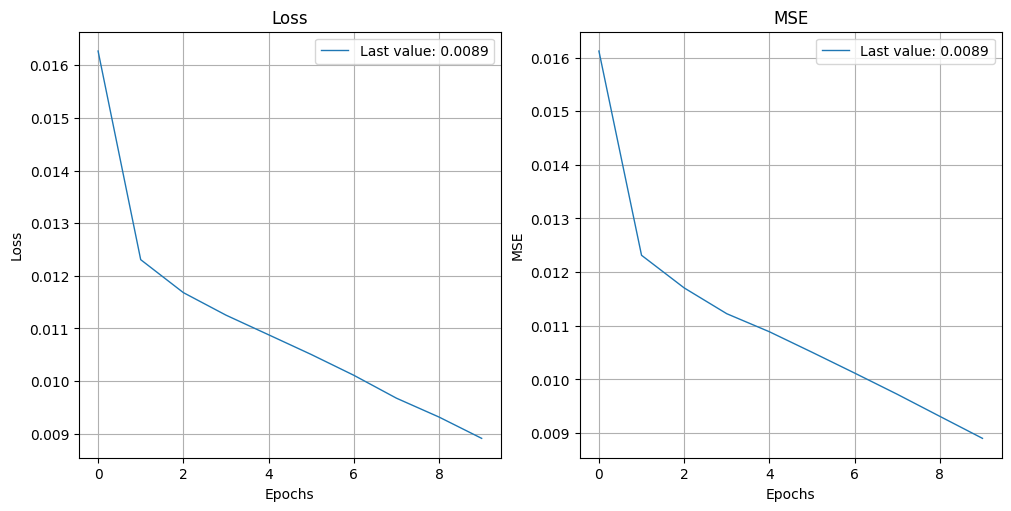

In [ ]:
plot_history(history.history, path="std.png")
plt.show()

Your results may be different depending on the implementation but typically special preprocessing does not drastically change the performance for this task.